# Pybullet env, YCB object load and motion primitives

In [1]:
cd ..

/home/p300488/LMM_utils/LMM-grasp-anything/OWG


In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyBboxPatch
from pprint import pprint

# helper function
%matplotlib inline
def display_image(path_or_array, size=(10, 10)):
  if isinstance(path_or_array, str):
    image = np.asarray(Image.open(open(image_path, 'rb')).convert("RGB"))
  else:
    image = path_or_array
  
  plt.figure(figsize=size)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

## Setup Pybullet Env

In [4]:
from owg_robot.env import *
from owg_robot.camera import Camera
from owg_robot.objects import YcbObjects

pybullet build time: Nov 28 2023 23:52:03


In [5]:
#p.disconnect()

# load camera and env
center_x, center_y, center_z = CAM_X, CAM_Y, CAM_Z
camera = Camera((center_x, center_y, center_z), (center_x, center_y, 0.785), 0.2, 2.0, (448, 448), 40)
env = Environment(camera, vis=True, asset_root='./owg_robot/assets', debug=False, finger_length=0.06)

# CAM_X, CAM_Y, CAM_Z = 0.05, -0.52, 1.9
# position = (0.05, -1.12, 1.5)
# orientation = (np.pi / 4 + np.pi / 16, np.pi, np.pi)
# image_size = (720, 720)
# intrinsics = (360., 0, 360., 0, 360., 360., 0, 0, 1)
# camera = Camera2(position, orientation, image_size, intrinsics, noise=False)

#env = Environment(camera, vis=True, asset_root='./owg_robot/assets', debug=False, finger_length=0.06)

# load objects
objects = YcbObjects('./owg_robot/assets/ycb_objects',
                    mod_orn=['ChipsCan', 'MustardBottle', 'TomatoSoupCan'],
                    mod_stiffness=['Strawberry'],
                    seed=23
)
objects.shuffle_objects()

n_objects = 5

for obj_name in objects.obj_names[:n_objects]:
    path, mod_orn, mod_stiffness = objects.get_obj_info(obj_name)
    env.load_isolated_obj(path, obj_name, mod_orn, mod_stiffness)
env.dummy_simulation_steps(10)

In [6]:
s0 = env.get_obj_states()

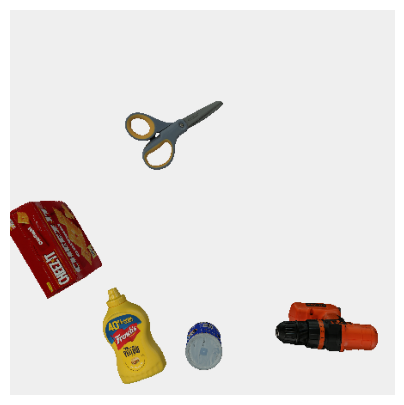

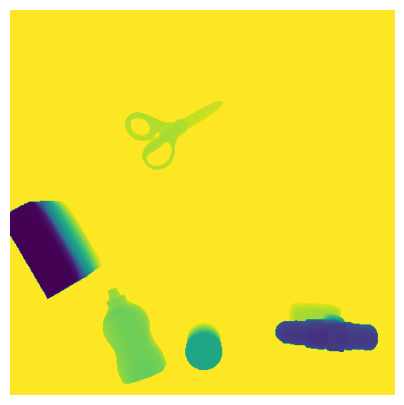

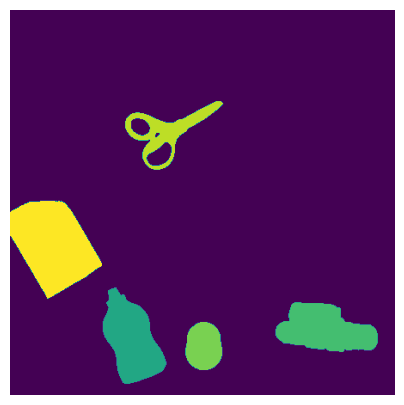

In [7]:
# visualize percepts
obs = env.get_obs()
display_image(obs['image'], size=(5,5))
display_image(obs['depth'], size=(5,5))
display_image(obs['seg'], size=(5,5))

In [8]:
# show object state
state = env.get_obj_states()
state_ids = {int(x['id']): x for x in state}
pprint(state_ids)

{6: {'id': 6,
     'name': 'MustardBottle',
     'orn': (0.6065258669209899,
             -0.3667675448625324,
             -0.5615698247956252,
             -0.4269042898241511),
     'pos': (-0.0927835522128006, -0.81265864948294, 0.8164260920649801)},
 7: {'id': 7,
     'name': 'PowerDrill',
     'orn': (0.015389590986424994,
             -0.014842601678165836,
             0.9992913718612185,
             0.030977601398715995),
     'pos': (0.2928820207588626, -0.7582552042896138, 0.8483089131787838)},
 8: {'id': 8,
     'name': 'MasterChefCan',
     'orn': (-3.1094610417088306e-05,
             -6.102392542708566e-06,
             0.8337884105444502,
             0.5520841289492437),
     'pos': (0.04894161016096189, -0.8082509299893799, 0.8372467870654831)},
 9: {'id': 9,
     'name': 'Scissors',
     'orn': (-0.0027844479012602633,
             0.03680488843299998,
             0.3291976593457609,
             0.9435393728502229),
     'pos': (-0.009799578551955509, -0.366666583

## GR-ConvNet integration

In [9]:
import importlib
import third_party.grconvnet
importlib.reload(third_party.grconvnet)
from third_party.grconvnet import *
import owg.utils.grasp; importlib.reload(owg.utils.grasp); from owg.utils.grasp import Grasp2D

grasp_generator = load_grasp_generator(camera)

INFO:root:CUDA detected. Running with GPU acceleration.


224 224


<Figure size 1000x1000 with 0 Axes>

In [10]:
def setup_grasps(env, grasp_generator, visualise_grasps=False):
        rgb, depth, seg = env.camera.get_cam_img()    
        img_size = grasp_generator.IMG_WIDTH
        if  img_size != camera.width: 
            rgb = cv2.resize(rgb, (img_size, img_size))
            depth = cv2.resize(depth, (img_size, img_size))
        for obj_id in env.obj_ids:
            mask = seg == obj_id
            if img_size != camera.width:
                mask = np.array(Image.fromarray(mask).resize((img_size, img_size), Image.LANCZOS))
            grasps, grasp_rects = grasp_generator.predict_grasp_from_mask(rgb,
                                                           depth,
                                                           mask,
                                                           n_grasps=5, 
                                                           show_output=True
            )
            if img_size != camera.width:
                # normalize to original size
                for j, gr in enumerate(grasp_rects):
                    grasp_rects[j][0] = int(gr[0] / img_size * camera.width)
                    grasp_rects[j][1] = int(gr[1] / img_size * camera.width)
                    grasp_rects[j][4] = int(gr[4] / img_size * camera.width)
                    grasp_rects[j][3] = int(gr[3] / img_size * camera.width)
            grasp_rects = [Grasp2D.from_vector(
                x=g[1], y=g[0], w=g[4], h=g[3], theta=g[2], W=camera.width, H=camera.width, normalized=False, line_offset=5,
            ) for g in grasp_rects]
            env.set_obj_grasps(obj_id, grasps, grasp_rects)
        
        if visualise_grasps:
            LID =[]
            for obj_id in env.obj_ids:
                grasps = env.get_obj_grasps(obj_id)
                color = np.random.rand(3).tolist()
                for g in grasps:
                    LID = env.draw_predicted_grasp(g,color=color,lineIDs=LID)
            
            time.sleep(1)
            env.remove_drawing(LID)
            env.dummy_simulation_steps(10)

In [11]:
# run and visualize grasps
setup_grasps(env, grasp_generator, visualise_grasps=True)

<Figure size 640x480 with 0 Axes>

In [12]:
# you can now retrieve them from sim state
obj_id = 7 # mustard
print('3D Grasps', env.get_obj_grasps(obj_id))
# format: (x, y, z, yaw_rotation, gripper_open_length, obj_height) - topdown grasp so roll,pitch are fixed to pi/2 and 0
print('2D Grasp Rectangles', env.get_obj_grasp_rects(obj_id))

3D Grasps [(0.30812274368231046, -0.799783393501805, 0.9720583308669843, 0.1659239093449454, 0.043221341838007396, 0.18705833086698442), (0.3117328519855596, -0.7420216606498194, 0.8099489189291036, 0.11979539791611238, 0.05050662019978399, 0.02494891892910367), (0.28285198555956687, -0.7961732851985559, 0.9711280220685224, 0.18184204498795076, 0.04440035094385562, 0.18612802206852253)]
2D Grasp Rectangles [Grasp2D(Vector: (366, 378, 32, 28, 0.1659239093449454), Rectangle: [[352.53203182 361.54965553]
 [384.09254959 366.83489143]
 [379.46796818 394.45034447]
 [347.90745041 389.16510857]]), Grasp2D(Vector: (368, 346, 32, 32, 0.11979539791611238), Rectangle: [[354.02681545 328.20252508]
 [385.79747492 332.02681545]
 [381.97318455 363.79747492]
 [350.20252508 359.97318455]]), Grasp2D(Vector: (352, 376, 32, 29, 0.18184204498795076), Rectangle: [[338.88600663 358.84560762]
 [370.35839841 364.63253732]
 [365.11399337 393.15439238]
 [333.64160159 387.36746268]])]


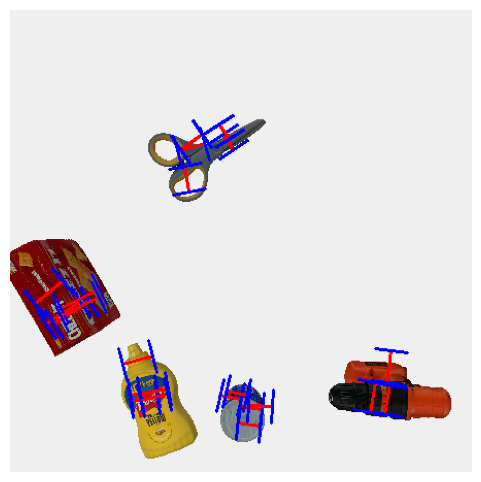

In [13]:
#tmp = cv2.resize(obs['image'], (224, 224))
tmp = obs['image'].copy()
for gs in env.obj_grasp_rects:
    for g in gs:
        tmp = g.annotate_in_frame(tmp)
display_image(tmp, (6,6))

## Robot primitives

In [14]:
def reset_robot(env):
    env.reset_robot()
    env.dummy_simulation_steps(10)

def reset_everything(env):
    env.reset_robot()
    env.dummy_simulation_steps(10)
    env.set_obj_state(s0)
    env.dummy_simulation_steps(10)
    env.update_obj_states()
    setup_grasps(env, grasp_generator)
    env.dummy_simulation_steps(10)
    
def update(env):
    env.dummy_simulation_steps(10)
    env.update_obj_states()
    setup_grasps(env, grasp_generator)
    env.dummy_simulation_steps(10)

#### Move to pose

In [15]:
# move ee primitive
ee_x, ee_y, ee_z = (0.2931718450049454, -0.7588325548315147, 0.8483096791687804)  # power drill center from state
ee_z += 0.35 # go a bit higher
ee_orn = p.getQuaternionFromEuler([-np.pi*0.25, np.pi/2, 0.0]) # approach from above

_ = env.move_ee([ee_x, ee_y, ee_z, ee_orn])

In [16]:
reset_robot(env)

#### Pick object

In [17]:
target_id = 6 # mustard bottle object from state

_ = env.pick_obj_by_id(target_id)

#### Place in table location

In [18]:
reset_everything(env)

<Figure size 640x480 with 0 Axes>

In [19]:
target_id = 6 # mustard bottle object
target_loc = "bottom left corner"
_ = env.put_obj_in_loc(target_id, target_loc)

Grasping failed. Retrying...


#### Place in exact position

In [20]:
reset_everything(env)

<Figure size 640x480 with 0 Axes>

In [21]:
target_id = 6 # mustard bottle object from state

ee_y += 0.1 # go a bit in front
ee_x -= 0.05 # bit to the right
ee_z += 0.05 # and a bit higher
target_loc = [ee_x, ee_y, ee_z]

_ = env.put_obj_in_loc(target_id, target_loc)

#### Put in tray

In [22]:
reset_everything(env)

<Figure size 640x480 with 0 Axes>

In [23]:
# `pick` primitive - put objects in tray
target_names = ['PowerDrill', 'Scissors', 'CrackerBox', 'MustardBottle', 'MasterChefCan'] # power drill, scissors, cracker box

for tgt in target_names:
    env.move_to_init_pos()
    update(env)
    tgt = env.get_obj_id_by_name(tgt)
    print(tgt)
    env.put_obj_in_tray(tgt)

7
9
Grasping failed. Retrying...
10
Grasping failed. Retrying...
Grasping failed. Retrying...
Grasping failed. Retrying...
Exceeded 3 grasping attempts.s
Grasping failed. Exitting
6
8


<Figure size 640x480 with 0 Axes>

#### Put in free space

In [26]:
reset_everything(env)

<Figure size 640x480 with 0 Axes>

In [27]:
# `remove` primitive - put objects in available free space
target_names = ['CrackerBox', 'MustardBottle', 'MasterChefCan'] # power drill, scissors, cracker box

for tgt in target_names:
    env.move_to_init_pos()
    update(env)
    tgt = env.get_obj_id_by_name(tgt)
    print(tgt)
    env.put_obj_in_free_space(tgt)

10
Grasping failed. Retrying...
Grasping failed. Retrying...
Grasping failed. Retrying...
6
8


<Figure size 640x480 with 0 Axes>

In [28]:
p.disconnect()